# Case Study: Forecasting Streamflow (CAMELS)

In this section, I will present a forecasting example using a data set from CAMELS.

In [1]:
from pywddff.datasets import get_camels_subset

camels_subset = get_camels_subset()
camels_ids = list(camels_subset.keys())
df = camels_subset[camels_ids[0]]
df

,Q(ft3/s),dayl(s),prcp(mm/day),srad(W/m2),tmax(C),tmin(C),vp(Pa)
0,18.00,34905.61,0.00,175.32,9.00,2.46,720.00
1,15.00,34905.61,0.00,289.07,11.50,-2.51,519.54
2,13.00,34905.61,0.00,297.24,11.99,-3.00,480.00
3,13.00,34905.61,2.26,190.21,8.55,-0.50,600.00
4,33.00,34905.61,5.49,151.74,5.50,-2.00,520.00
...,...,...,...,...,...,...,...
11226,0.02,42508.80,0.00,302.88,29.16,18.00,2080.05
11227,0.47,42163.21,26.81,120.50,22.49,17.21,1953.55
11228,0.50,42163.21,14.10,207.48,23.97,14.50,1640.00
11229,0.69,42163.21,12.19,161.60,22.21,15.13,1730.51


Let's plot the target variable using an arbitrary time index.

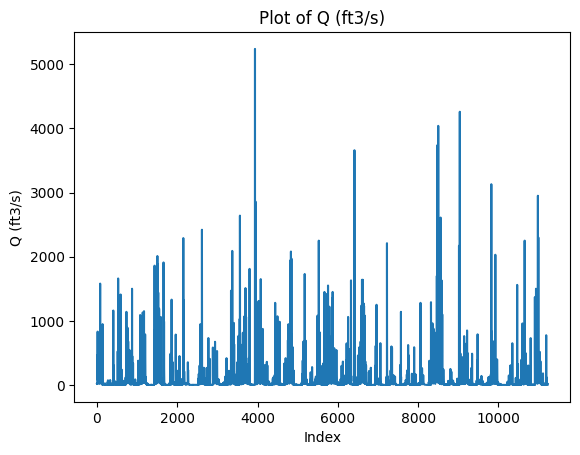

In [2]:
import matplotlib.pyplot as plt

# Let's plot the data
df['Q(ft3/s)'].plot(kind='line')
plt.xlabel('Index')
plt.ylabel('Q (ft3/s)')
plt.title('Plot of Q (ft3/s)')
plt.show()

## Add coefficient features

The choice of `filter` and `J` (decomposition level) is not trivial, and ideally we should use grid search over multiple filters and decomposition levels. Here, we will choose `filter = "la8"` and a decomposition level of `J = 2`.

In [3]:
from pywddff.pywddff import multi_stationary_dwt

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

X_new, y_new = multi_stationary_dwt(X, y, 
                                    transform = 'atrousdwt', 
                                    filter = 'la8', 
                                    J = 2, 
                                    remove_bc = True, 
                                    approach = "single hybrid")
list(X_new)

['dayl(s)',
 'prcp(mm/day)',
 'srad(W/m2)',
 'tmax(C)',
 'tmin(C)',
 'vp(Pa)',
 'dayl(s)_W1',
 'dayl(s)_W2',
 'dayl(s)_V2',
 'prcp(mm/day)_W1',
 'prcp(mm/day)_W2',
 'prcp(mm/day)_V2',
 'srad(W/m2)_W1',
 'srad(W/m2)_W2',
 'srad(W/m2)_V2',
 'tmax(C)_W1',
 'tmax(C)_W2',
 'tmax(C)_V2',
 'tmin(C)_W1',
 'tmin(C)_W2',
 'tmin(C)_V2',
 'vp(Pa)_W1',
 'vp(Pa)_W2',
 'vp(Pa)_V2']

## Leading the target variable

For the purpose of this case study, I will do 2 days ahead forecasting.

In [4]:
from pywddff.utils import prep_forecast_data

h = 2 # forecast horizon (2 days ahead in this case)

X_new, y_new = prep_forecast_data(X_new, y_new, h = h)

## Data splitting

Here, I will split our data set into train, validation and test sets.

In [5]:
from pywddff.utils import absolute_split_3

X_train, X_val, X_test, y_train, y_val, y_test = absolute_split_3(X_new.to_numpy(), 
                                                                  y_new.to_numpy(), 
                                                                  nval = 2*365, 
                                                                  ntest = 365)

## Correlation matrix

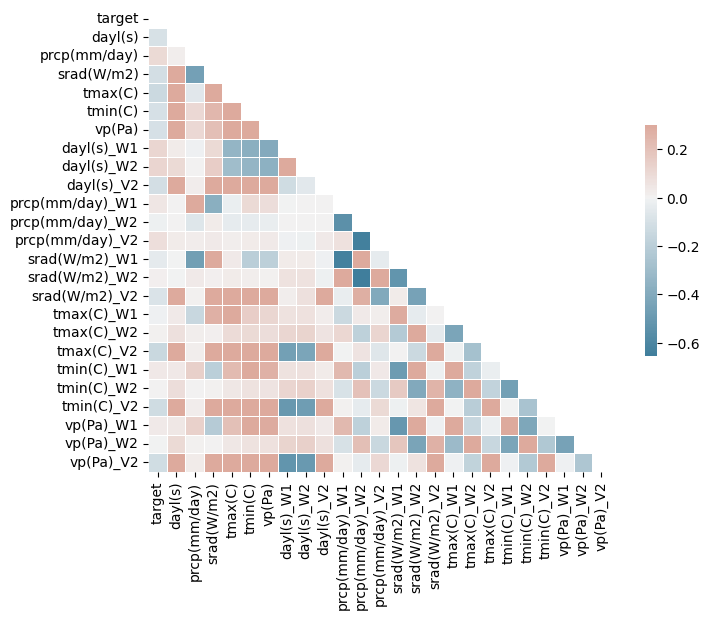

In [6]:
import seaborn as sns
import numpy as np
import pandas as pd

arr = np.column_stack((y_train, X_train))

# Create a pandas DataFrame from the array
arr_df = pd.DataFrame(arr, columns=['target'] + list(X_new))

# Compute the correlation matrix
corr = arr_df.corr()

# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

## Model comparison

Best model based on validation NSE is: Support Vector Regression
Test NSE for the best model is: -0.014246825269703445


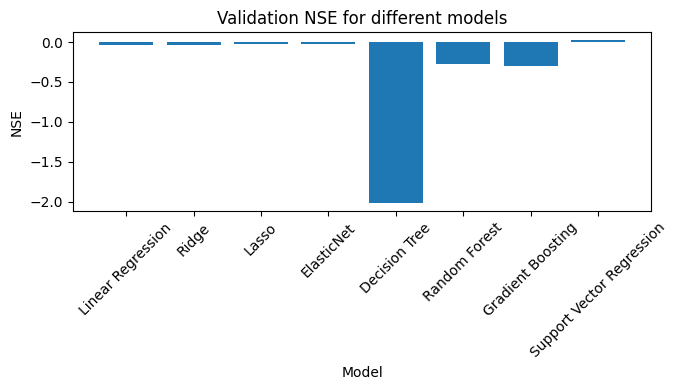

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Assume that your arrays are loaded correctly

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR()
}

# Function to calculate Nash Sutcliffe Efficiency Coefficient
def nse(y_obs, y_pred):
    return 1 - sum((y_obs - y_pred) ** 2) / sum((y_obs - np.mean(y_obs)) ** 2)

# Apply feature scaling to the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store the validation scores of the models
validation_scores = {}

for name in models:
    model = models[name]
    model.fit(X_train_scaled, y_train)  # Train the model
    predictions = model.predict(X_val_scaled)  # Generate predictions on the validation set
    nse_score = nse(y_val, predictions)  # Compute NSE
    validation_scores[name] = nse_score

# Select the best model based on validation NSE
best_model_name = max(validation_scores, key=validation_scores.get)
best_model = models[best_model_name]

print(f"Best model based on validation NSE is: {best_model_name}")

# Compute the test NSE for the best model
test_predictions = best_model.predict(X_test_scaled)
nse_test = nse(y_test, test_predictions)

print(f"Test NSE for the best model is: {nse_test}")

# Create a bar plot of the validation NSEs
plt.figure(figsize=(7, 4))
plt.bar(validation_scores.keys(), validation_scores.values())
plt.title('Validation NSE for different models')
plt.xlabel('Model')
plt.ylabel('NSE')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

All in all, terrible results, but that was not the point. Here you saw a basic ML forecasting example involving wavelet feature engineering using the `pywddff` package.